In [ ]:
# default_exp funcs.train_funcs

In [ ]:
%load_ext autoreload
%autoreload 2
%aimport -decode_fish.engine.place_psfs

# Training loop simulator learning

In [ ]:
#export
from decode_fish.imports import *
from decode_fish.funcs.matching import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.output_trafo import *
from decode_fish.funcs.plotting import *
from decode_fish.funcs.predict import *
from decode_fish.funcs.visualization import *
import torch.nn.functional as F
from torch import distributions as D
from torch.utils.data import DataLoader
import torch_optimizer
from decode_fish.engine.microscope import Microscope, get_roi_filt_inds, extract_psf_roi, mic_inp_apply_inds, add_pos_noise
from decode_fish.engine.model import UnetDecodeNoBn_2S
from decode_fish.engine.point_process import PointProcessUniform, get_phased_ints
from decode_fish.engine.gmm_loss import PointProcessGaussian
import shutil
import wandb
import kornia

from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *
from decode_fish.funcs.exp_specific import *
# from decode_fish.funcs.visualization vimport get_simulation_statistics

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

In [ ]:
#export
def eval_logger(pred_df, target_df, iteration, data_str='Sim. '):
    
    perf_dict,matches,shift = matching(target_df, pred_df, print_res=False,  match_genes=True)
    if 'Inp' in data_str:
        pred_corr = shift_df(pred_df, shift)
        perf_dict, _, _ = matching(target_df, pred_corr, print_res=False,  match_genes=True)

    wandb.log({data_str +'Metrics/eff_3d': perf_dict['eff_3d']}, step=iteration)
    wandb.log({data_str +'Metrics/jaccard': perf_dict['jaccard']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_vol': perf_dict['rmse_vol']}, step=iteration)

    wandb.log({data_str +'Metrics/precision': perf_dict['precision']}, step=iteration)
    wandb.log({data_str +'Metrics/recall': perf_dict['recall']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_x': perf_dict['rmse_x']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_y': perf_dict['rmse_y']}, step=iteration)
    wandb.log({data_str +'Metrics/rmse_z': perf_dict['rmse_z']}, step=iteration)   
    
    return matches

def save_train_state(save_dir, model, microscope, optim_dict, train_iter, checkpoint=False):
    
    if checkpoint:
        
        save_dir = save_dir/'checkpoint/'
        os.makedirs(save_dir, exist_ok=True)
    
    torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/'model.pkl')
    torch.save(microscope.state_dict(), save_dir/'microscope.pkl')

    save_dict = {k:v.state_dict() for (k,v) in optim_dict.items()}
    save_dict['train_iter'] = train_iter

    torch.save(save_dict, save_dir/'training_state.pkl')
        
def exp_train_eval(bench_df, res_df, targets, wandb, batch_idx):
    
    if len(res_df):
    
        res_sub = res_df.nsmallest(len(bench_df), 'int_ratio')

        bench_counts = DF(data=None, index=targets)
        bench_counts['Res_all'] = res_sub.groupby('gene')['gene'].count()
        bench_counts['Bench_all'] = bench_df.groupby('gene')['gene'].count()
        bench_counts = bench_counts.fillna(0)
        
        r = np.corrcoef(bench_counts['Bench_all'].values, bench_counts['Res_all'].values)[0, 1]   

        blinds = []
        for i,g in enumerate(targets):
            if 'Blank' in g:
                blinds.append(g)

        bc = bench_counts.loc[blinds,'Res_all'].values.sum()
        bench_bc = bench_counts.loc[blinds,'Bench_all'].values.sum()
        
        bench_df['z'] = bench_df['z']/1000
        res_sub['z'] = res_sub['z']/100
        
        wandb.log({'AE Losses/code_bench_corr': r}, step=batch_idx)
        wandb.log({'AE Losses/N_blanks': bc/bench_bc}, step=batch_idx)
        
        perf_dict, match_df, shifts = matching(bench_df,  res_sub, tolerance=500)
        wandb.log({'AE Losses/jaccard': perf_dict['jaccard']}, step=batch_idx)        
        
    wandb.log({'AE Losses/N_pred_tot': len(res_df)/len(bench_df)}, step=batch_idx)

In [ ]:
#export 
def train(cfg,
          model, 
          micro,
          post_proc,
          dl, 
          optim_dict):
    
    """
    Training loop for autoencoder learning. Alternates between a simulator training step to train the inference network
    and an autoencoder step to train the PSF (and micro) parameters.
    
    Args:
        model (torch.nn.Module): DECODE 3D UNet.
        micro (torch.nn.Module): Microscope class that transforms emitter locations into simulated images.
        post_proc (torch.nn.Module): Post processing class that transforms emitter probilities deterministically into binary outputs.
        dl  (torch.utils.data.dataloader.DataLoader): Dataloader that returns a random sub volume from the real volume, an estiamted emitter density and background.
        optim_dict (dict of torch.optim.Optimizer and torch.optim.lr_scheduler): Dict. with optimizer and scheduler objects for the network and gen. model parameters.
        
    """ 
    
    save_dir = Path(cfg.output.save_dir)
    bench_df = None

    model.cuda().train()
    
    # Load codebook 
    codebook, targets = hydra.utils.instantiate(cfg.codebook)
    
    # If our network is also trained to predict single-channel emitters, expand the codebook with single-bit codes
    sim_codebook = torch.tensor(codebook, dtype=torch.bool) if not cfg.genm.exp_type.em_noise_inf else torch.tensor(expand_codebook(codebook), dtype=torch.bool)
    post_proc.codebook = sim_codebook
    code_weight = torch.ones(len(sim_codebook))
    code_weight[len(codebook):] *= cfg.genm.emitter_noise.rate_fac
    
    # Load particle sampler
    point_process = PointProcessUniform(**cfg.genm.intensity_dist, sim_iters=5, n_channels=cfg.genm.exp_type.n_channels, sim_z=cfg.genm.exp_type.pred_z, slice_rec=cfg.genm.exp_type.slice_rec, 
                                        codebook=sim_codebook, int_option=cfg.training.int_option, code_weight=code_weight)
    
    # Controls which genmodel parameters are optimized
    for name, p in micro.named_parameters(recurse=False):
        p.requires_grad = cfg.training.mic.par_grads[name]    
    micro.psf.psf_volume.requires_grad_(cfg.training.mic.par_grads['psf_vol'])

    calc_log_p_x = False
    int_sig = None
    zcrop, ycrop, xcrop, colshift_crop = None, None, None, None
    
    # Hacky way to switch between network / genmodel training
    if cfg.training.schedule is not None:
        sched = cfg.training.schedule
        cfg.training.net.enabled = True
        cfg.training.mic.enabled = False
        switch_iter = sched.pop(0)
    
    for batch_idx in range(cfg.training.start_iter, cfg.training.num_iters+1):
        
        if cfg.training.schedule is not None:
            if batch_idx == switch_iter:
                cfg.training.net.enabled = not(cfg.training.net.enabled)
                cfg.training.mic.enabled = not(cfg.training.mic.enabled)
                switch_iter += sched.pop(0)

        t0 = time.time()
        # Get real data window and rate/background for the simulation
        ret_dict = next(iter(dl))
        x, local_rate, background = ret_dict['x'], ret_dict['local_rate'], ret_dict['background'] 
        
        # If we learn color shifts (aberation maps) we also need to know where we picked the data
        if cfg.genm.microscope.col_shifts_enabled:
            zcrop, ycrop, xcrop = ret_dict['crop_z'], ret_dict['crop_y'], ret_dict['crop_x']
            zcrop, ycrop, xcrop = zcrop.flatten(), ycrop.flatten(), xcrop.flatten()
            colshift_crop = get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx, ycrop, xcrop, cfg.sim.random_crop.crop_sz)
        
        # Scale real data and extracted background by the learned channel_facs
        background = background * micro.get_ch_mult().detach()
        x = x * micro.get_ch_mult().detach()
        
        # Shuffle background across channels so the network doesn't overfit to much
        if cfg.sim.bg_estimation.shuffle_ch:
            background = background.index_select(1, torch.randperm(background.shape[1]).cuda())

#         print('DL, ', time.time()-t0); t0 = time.time()
        
        if cfg.training.net.enabled:
    
            optim_dict['optim_net'].zero_grad()
            # Sample emitters
            sim_vars = point_process.sample(local_rate[:,0])

            # sim_vars = locs_sl, x_os_sl, y_os_sl, z_os_sl, ints_sl, output_shape, codes
            # locs_sl has the discrete positions of the barcodes in 4D (batch, 0, z, y, x), the channels are later determined. z = 0 for slice data
            # x_os_sl, y_os_sl, z_os_sl subpixel offsets. dim: N_barcodes
            # ints_sl array of intensities. dim: N_barcodes * n_channels
            # codes are the code indices.
            
#             print('Sim, ', time.time()-t0); t0 = time.time()

            # Extract the single channel inputs that the microscope takes as input (the microscope is 'unaware' of the codebook). Also applies color/round dependent shifts
            # ch_inp[0] not was has discrete positions in 5D (batch, channel, z, y, x)
            # offsets and intensities are now of shape N_psfs 
            ch_inp = list(micro.get_single_ch_inputs(*sim_vars[:-1], ycrop=ycrop, xcrop=xcrop))
            
            # Add random noise to multiple psfs belonging to the same barcode such that the mean position (which is the network target) remains unchanged
            ch_inp[1], ch_inp[2], ch_inp[3] = add_pos_noise([ch_inp[1], ch_inp[2], ch_inp[3]],  
                                                            [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, sim_vars[-1] < len(codebook))
            
            # Generate simulated images
            xsim = micro(*ch_inp, add_noise=True)
            
            # Add phasing. Seems to help slightly but slows down training 
            if cfg.genm.phasing:
                
                phasing_inp = list(micro.get_single_ch_inputs(*sim_vars[:4], get_phased_ints(sim_vars[4], micro.ch_cols, micro.psf.n_cols) ,sim_vars[5], ycrop=ycrop, xcrop=xcrop))
                phasing_inp[1:4] = add_pos_noise(phasing_inp[1:4], [cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_xy, cfg.genm.pos_noise.pos_noise_z], cfg.genm.exp_type.n_bits, rm_mean=False)
                # Phased PSFs are dimmer, also add some randomness
                xsim += micro(*phasing_inp, add_noise=True) * cfg.genm.phasing * torch.rand(xsim.shape, device=xsim.device)
                
#             print('Micro, ', time.time()-t0); t0 = time.time()
            
            # Sammple camera noise
            xsim_noise = micro.noise(xsim, background, randomize_range=cfg.genm.exp_type.randomize_noise_range).sample()

#             print('Noise. ', time.time()-t0); t0 = time.time()
            
            # Network takes the simulated image and the aberation maps
            net_inp = torch.concat([xsim_noise,colshift_crop], 1) if colshift_crop is not None else xsim_noise
            out_sim = model.tensor_to_dict(model(net_inp))
            
#             print('Model forw. ', time.time()-t0); t0 = time.time()

            # Calculate loss
            ppg = PointProcessGaussian(**out_sim)
            count_prob, spatial_prob = ppg.log_prob(*sim_vars[:5], codes=sim_vars[-1], n_channels=cfg.genm.exp_type.n_channels, loss_option=cfg.training.loss_option, int_inf=cfg.genm.exp_type.int_inf)
            gmm_loss = -(spatial_prob + cfg.training.net.cnt_loss_scale*count_prob).mean()

            background_loss = F.mse_loss(out_sim['background'], background)

            loss = gmm_loss + background_loss * cfg.training.net.bl_loss_scale
            
#             print('Loss calc. ', time.time()-t0); t0 = time.time()

            # Update network parameters
            loss.backward()

            if cfg.training.net.grad_clip: torch.nn.utils.clip_grad_norm_(model.network.parameters(), max_norm=cfg.training.net.grad_clip, norm_type=2)

            optim_dict['optim_net'].step()
            optim_dict['sched_net'].step()
            
            # After a warm-up period we also optimize channel factors in each iteration (less frequent updates would probably be enough)
            # Channels factors are stored in the microscope but DO NOT influence the simulation. They are just used to scale real data such that the inferred intensities are constant across channels

            if cfg.training.mic.par_grads.channel_facs and batch_idx > cfg.training.start_channel_scaling:
                
                with torch.no_grad():
                    
                    # Run network on real data
                    net_inp = torch.concat([x,colshift_crop], 1) if colshift_crop is not None else x
                    out_inp = model.tensor_to_dict(model(net_inp))
                    # Remove single emitters. They have a different intentsity distribution the emitters that belong to barcodes apparently
                    out_inp['logits'][:,len(codebook):] = -20.

                    proc_out_inp = post_proc.get_micro_inp(out_inp)  
                    ch_out_inp = micro.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop, xcrop=xcrop)
                    
                if len(proc_out_inp[1]) > 0:
                    
                    optim_dict['optim_mic'].zero_grad()

                    # Get ch_fac loss
                    ch_inds = ch_out_inp[0][1]
                    int_vals = ch_out_inp[-2]                

                    target_mean_int = cfg.genm.intensity_dist.int_conc / cfg.genm.intensity_dist.int_rate + cfg.genm.intensity_dist.int_loc

                    int_means = torch.ones(cfg.genm.exp_type.n_channels).cuda()
                    
                    # Collect inensities across channels
                    for i in range(cfg.genm.exp_type.n_channels):
                        if i in ch_inds:
                            int_means[i] = int_vals[ch_inds == i].mean() 
                            if not cfg.training.target_mean:
                                int_means[i] = int_means[i] / int_vals.mean()
                            else:
                                int_means[i] = int_means[i] / target_mean_int

                    # Loss becomes zero if int_means are all 1.
                    ch_fac_loss = torch.sqrt(torch.mean((micro.channel_facs - micro.channel_facs.detach() / int_means)**2))   
                    ch_fac_loss.backward()
                    int_sig = torch.sqrt(torch.var(int_means))
                    
                    optim_dict['optim_mic'].step()

        ch_out_inp = [[],[]]    
        if cfg.training.mic.enabled:
            
#             out_inp = model.tensor_to_dict(model(x))
            net_inp = torch.concat([x,colshift_crop], 1) if colshift_crop is not None else x
            out_inp = model.tensor_to_dict(model(net_inp))
            proc_out_inp = post_proc.get_micro_inp(out_inp)

            if cfg.training.mic.enabled and len(proc_out_inp[1]) > 0: # and len(proc_out_inp[1]) < 300:
# #                 print('Pre filt ', len(proc_out_inp[1]))
                ch_out_inp = micro.get_single_ch_inputs(*proc_out_inp, ycrop=ycrop, xcrop=xcrop)
                optim_dict['optim_mic'].zero_grad()
                calc_log_p_x = False
            
                # Get autoencoder loss
                if cfg.training.mic.roi_rec:
                    # Select isolated emitters
                    filt_inds = get_roi_filt_inds(*ch_out_inp[0], micro.psf.psf_volume.shape, x.shape, slice_rec=cfg.genm.exp_type.slice_rec, min_dist=10)
                    ch_out_inp = mic_inp_apply_inds(*ch_out_inp, filt_inds)
                    
                    if len(ch_out_inp[1]):
                        # Get PSF reconstructions
                        psf_recs = micro(*ch_out_inp, ret_psfs=True, add_noise=False)  
                        n_recs = len(psf_recs)
# #                         print('N rec inds ', len(psf_recs))
                        
                        # Extract rois and background from real data / network output
                        rois = extract_psf_roi(ch_out_inp[0], x, torch.tensor(psf_recs.shape))
                        bgs = extract_psf_roi(ch_out_inp[0], out_inp['background'], torch.tensor(psf_recs.shape))
                
                        # Correct for difference in the mean between reconstructions and rois
                        if cfg.training.mic.mean_diff:
                            mean_diff = rois.mean([1,2,3,4], keepdim=True) - (psf_recs.detach()+bgs).mean([1,2,3,4], keepdim=True)
                            rois -= mean_diff
                        
                        log_p_x_given_z = -micro.noise(psf_recs, bgs, ch_inds=ch_out_inp[0][1]).log_prob(rois.clamp_min_(1.))

                        log_p_x_given_z = log_p_x_given_z.mean()
                        calc_log_p_x = True
                        
                else:
                    # Reconstruct full 5D volume instead, will probably run out of memory
                    ae_img = micro(*ch_out_inp, add_noise=False)
                    log_p_x_given_z = -micro.noise(ae_img, out_inp['background']).log_prob(x.clamp_min_(1.)).mean()
                    calc_log_p_x = True
                    
                if calc_log_p_x:       
                    
                    # Regularization to keep the psf centered
#                     if cfg.training.psf.norm_reg:
#                         log_p_x_given_z += cfg.training.psf.norm_reg * (micro.psf.com_loss())
                    
                    # L1 regularization on the difference to the initial psf. Doesn't seem to help anymore
#                     if cfg.training.psf.l1_reg:
#                         log_p_x_given_z += cfg.training.psf.l1_reg * (micro.psf.l1_diff_norm(micro.psf_init_vol))  

                    log_p_x_given_z.backward()
                    if cfg.training.mic.grad_clip: torch.nn.utils.clip_grad_norm_(micro.parameters(recurse=False), max_norm=cfg.training.mic.grad_clip, norm_type=2)
                    if cfg.training.mic.grad_clip: torch.nn.utils.clip_grad_norm_(micro.psf.parameters(), max_norm=cfg.training.psf.grad_clip, norm_type=2)

                    optim_dict['optim_mic'].step()
                    optim_dict['optim_psf'].step()
                    
                optim_dict['sched_mic'].step()
                optim_dict['sched_psf'].step()
              

        # Logging
        if batch_idx == cfg.training.checkpoint:
            save_train_state(save_dir, model, micro, optim_dict, batch_idx, checkpoint=True) 
    
        if batch_idx % 10 == 0:
            
            if cfg.training.net.enabled:
            
                wandb.log({'SL Losses/xyz_loss': spatial_prob.mean().detach().cpu().item()}, step=batch_idx)
                wandb.log({'SL Losses/count_loss': (-count_prob.mean()).detach().cpu()}, step=batch_idx)
                wandb.log({'SL Losses/bg_loss': background_loss.detach().cpu()}, step=batch_idx)
            
                if int_sig is not None:
                    wandb.log({'AE Losses/int_sig': int_sig.item()}, step=batch_idx)
        
            if cfg.training.mic.enabled: 
                if cfg.training.mic.enabled and calc_log_p_x:
                    wandb.log({'AE Losses/p_x_given_z': log_p_x_given_z.detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/n_recs': n_recs}, step=batch_idx)
                    wandb.log({'AE Losses/RMSE(rec)': torch.sqrt(((rois-(psf_recs+bgs))**2).mean()).detach().cpu()}, step=batch_idx)
                    wandb.log({'AE Losses/sum(psf)': F.relu(micro.psf.psf_volume/micro.psf.psf_volume.max())[0].sum().detach().cpu()}, step=batch_idx)
        
#         if batch_idx > 0 and batch_idx % 1500 == 0:
#             torch.save({'state_dict':model.state_dict(), 'scaling':[model.inp_scale, model.inp_offset]}, save_dir/f'model_{batch_idx}.pkl')
    
        if batch_idx % cfg.output.log_interval == 0 and batch_idx > 1200:
            print(batch_idx)

            if cfg.training.net.enabled:
                
                with torch.no_grad():

                    pred_df = post_proc.get_df(out_sim)
                    px_size = cfg.evaluation.px_size_zyx
                    target_df = sample_to_df(*sim_vars[:5], sim_vars[-1], px_size_zyx=px_size)
    #                 print(len(pred_df), len(target_df))
                    matches = eval_logger(pred_df[:5*len(target_df)], target_df, batch_idx, data_str='Sim. ')

                    wandb.log({'Sim. Metrics/prob_fac': torch.sigmoid(out_sim['logits']).sum().item()/(len(target_df)+0.1)}, step=batch_idx)
                    wandb.log({'Sim. Metrics/n_em_fac': len(pred_df)/(len(target_df)+0.1)}, step=batch_idx)

                    if cfg.output.log_figs:

                        sl_fig = sl_plot(x, xsim_noise, nm_to_px(pred_df, px_size), nm_to_px(target_df, px_size), background, out_sim, from_records=dl.dataset.from_records)
                        plt.show()
                        wandb.log({'SL summary': sl_fig}, step=batch_idx)


                    if cfg.evaluation.code_stats.enabled:

                        crop = eval(cfg.evaluation.code_stats.crop,{'__builtins__': None},{'s_': np.s_})
                        if bench_df is None:
                            bench_df = hydra.utils.call(cfg.evaluation.code_stats.bench_func, crop=crop)
                            
                        res_df = window_predict(model, post_proc, dl.dataset.volumes, window_size=[None, 64, 64], device='cuda', crop=crop, 
                                                chrom_map=get_color_shift_inp(micro.color_shifts, micro.col_shifts_yx)[:,:,None], scale=micro.get_ch_mult().detach())
                        
                        res_df = res_df[res_df['code_inds'] < len(codebook)]
                        res_df['gene'] = targets[res_df['code_inds']]
                        res_df = sel_int_ch(res_df, codebook)
                        wandb.log({'AE Losses/N_pred_tot_ppp': len(res_df)/len(bench_df)}, step=batch_idx)
                        res_df = res_df[:3*len(bench_df)] 
                        res_df = hydra.utils.call(cfg.evaluation.code_stats.df_postp_func, res_df=res_df)
                        exp_train_eval(bench_df, res_df, targets, wandb=wandb, batch_idx=batch_idx)


            # storing
            save_train_state(save_dir, model, micro, optim_dict, batch_idx) 
            
#             print('Log., ', time.time()-t0); t0 = time.time()
            
    wandb.finish()

In [ ]:
cfg = OmegaConf.load('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish//MERFISH_sweep_gen_11/no_ch_shifts///train.yaml')
# cfg = OmegaConf.load(f'../config/experiment/MERFISH_mop_33.yaml')

cfg.output.log_interval = 100
cfg.training.bs = 2

micro = load_psf_noise_micro(cfg)
post_proc = hydra.utils.instantiate(cfg.post_proc_isi)

/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/psf.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psf_vol = torch.tensor(psf_vol, dtype=torch.float32).to(device)


In [ ]:
# cfg.data_path.model_init  = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_sim_int/sim_int_5_os/ae_train_emnp_esc//'
# cfg.training.mic.par_grads.channel_facs = False

In [ ]:
img_3d, decode_dl = get_dataloader(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 48, 48)
1 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_17/phasing:0.0'
# cfg.training.num_iters = 100000
# cfg.training.schedule = None
# cfg.training.mic.enabled = True

In [ ]:
# Heuristic estimation of offset/scale for the network is sufficient
if decode_dl.dataset.from_records:
    inp_offset, inp_scale = get_forward_scaling(img_3d[0])
else:
    inp_scale = 300
    inp_offset = 100
model = hydra.utils.instantiate(cfg.network, inp_scale=inp_scale, inp_offset=inp_offset)

model.to('cuda')
micro.to('cuda')

Microscope(
  (psf): LinearInterpolatedPSF()
  (noise): GammaNoise()
)

In [ ]:
# Three optimizers, for network / PSF volume / remaining gen. model parameters
optim_dict = {}
optim_dict['optim_net'] = hydra.utils.instantiate(cfg.training.net.opt, params=model.network.parameters())
optim_dict['optim_mic'] = hydra.utils.instantiate(cfg.training.mic.opt, params=micro.parameters(recurse=False))
optim_dict['optim_psf'] = hydra.utils.instantiate(cfg.training.psf.opt, params=[micro.psf.psf_volume])

optim_dict['sched_net'] = hydra.utils.instantiate(cfg.training.net.sched, optimizer=optim_dict['optim_net'])
optim_dict['sched_mic'] = hydra.utils.instantiate(cfg.training.mic.sched, optimizer=optim_dict['optim_mic'])
optim_dict['sched_psf'] = hydra.utils.instantiate(cfg.training.psf.sched, optimizer=optim_dict['optim_psf'])
    
save_dir = Path(cfg.output.save_dir)
save_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# cfg.data_path.model_init = cfg.output.save_dir
# cfg.data_path.model_init = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/MERFISH_MOp/sweep_mop_30/images47.tif/checkpoint/'

if cfg.training.resume:
    cfg.data_path.model_init = cfg.output.save_dir
    cfg.data_path.micro_init = cfg.output.save_dir

if cfg.data_path.model_init is not None:
    print('loading network')
    model = load_model_state(model, Path(cfg.data_path.model_init)/'model.pkl').cuda()

    if cfg.training.net.enabled:
        train_state_dict = torch.load(Path(cfg.data_path.model_init)/'training_state.pkl')
        for k in optim_dict:
            if 'net' in k:
                optim_dict[k].load_state_dict(train_state_dict[k])    

        cfg.training.start_iter = train_state_dict['train_iter']

if cfg.data_path.micro_init is not None:
    print('loading microscope')
    micro.load_state_dict(torch.load(Path(cfg.data_path.micro_init)/'microscope.pkl'), strict=False)
    
    if cfg.training.mic.enabled:
        train_state_dict = torch.load(Path(cfg.data_path.micro_init)/'training_state.pkl')
        for k in optim_dict:
            if 'mic' in k or 'psf' in k:
                optim_dict[k].load_state_dict(train_state_dict[k])  

loading network
loading microscope


In [ ]:
_ = wandb.init(project=cfg.output.project, 
               config=OmegaConf.to_container(cfg, resolve=True),
               dir=cfg.output.log_dir,
               group=cfg.output.group,
               name=cfg.run_name,
               mode='disabled'
          )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/engine/point_process.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.codebook = torch.tensor(codebook).to(self.device) if codebook is not None else None


9900


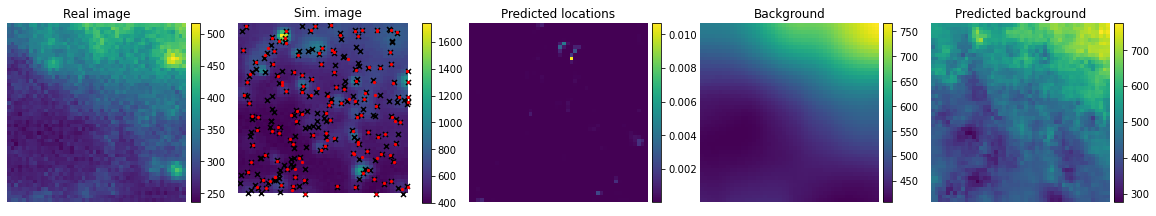

13832
torch.Size([1, 16, 1, 2048, 2048])
Recall: 0.629
Precision: 0.629
Jaccard: 45.929
RMSE_vol: 84.617
Eff_3d: 31.344
FN: 4652.0 FP: 4652.0
Num. matches: 7903.000
Shift: 1.19,1.02,-0.47
10000
tensor(0., device='cuda:0', grad_fn=<CopyBackwards>)
tensor(0.7055, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1.1954, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1.5182, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(1.8050, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(2.0207, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(2.2475, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(2.5862, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(2.9192, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(3.2396, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(3.5109, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(3.7588, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(3.9699, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(4.1671, device='cuda:0', grad_fn=<CopyBackwards>)
tensor(4.368

KeyboardInterrupt: 

In [ ]:
train(cfg=cfg,
     model=model, 
     micro=micro, 
     post_proc=post_proc,
     dl=decode_dl, 
     optim_dict=optim_dict)

In [ ]:
!nbdev_build_lib

Converted 00_models.ipynb.
Converted 01_psf.ipynb.
Converted 02_microscope.ipynb.
Converted 02b_place_psfs.ipynb.
Converted 03_noise.ipynb.
Converted 04_pointsource.ipynb.
Converted 05_gmm_loss.ipynb.
Converted 06_plotting.ipynb.
Converted 07_file_io.ipynb.
Converted 08_dataset.ipynb.
Converted 09_output_trafo.ipynb.
Converted 10_matching.ipynb.
Converted 11_emitter_io.ipynb.
Converted 12_utils.ipynb.
Converted 13_train.ipynb.
Converted 15_fit_psf.ipynb.
Converted 16_visualization.ipynb.
Converted 17_eval_routines.ipynb.
Converted 18_predict_funcs.ipynb.
Converted 19_MERFISH_routines.ipynb.
Converted 22_MERFISH_codenet.ipynb.
Converted 23_MERFISH_comparison.ipynb.
Converted 24_exp_specific.ipynb.
Converted 25_ensembling.ipynb.
Converted 26_gen_train.ipynb.
Converted 27_testtime_rescale.ipynb.
Converted index.ipynb.
